In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import pickle
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/anthony.rahbany/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.7f72a3c5.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Handle Data

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize with Mean and Standard Deviation
])

train_dataset = datasets.KMNIST('/blue/azare/anthony.rahbany/Data/Japanese_MNIST/', train=True, download=False, transform=transform)
test_dataset = datasets.KMNIST('/blue/azare/anthony.rahbany/Data/Japanese_MNIST/', train=False, download=False, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size   # 20% for validation
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class SmallMLP(nn.Module):
    def __init__(self):
        super(SmallMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)

class MediumMLP(nn.Module):
    def __init__(self):
        super(MediumMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)

class LargeMLP(nn.Module):
    def __init__(self):
        super(LargeMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)
    
class ExtraLargeMLP(nn.Module):
    def __init__(self):
        super(ExtraLargeMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)

class SuperLargeMLP(nn.Module):
    def __init__(self):
        super(SuperLargeMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
def evalution(model, dataloader, criterion, type="val"):
    model.eval()
    
    eval_loss = 0.0
    instance_count = 0
    eval_correct_amount = 0

    all_predictions, all_labels = [], []

    for batch_id, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)

        outputs = model(data)

        eval_loss += criterion(outputs, labels)

        # Compute Eval Accuracy
        eval_predictions = torch.max(outputs.data, 1)[1]
        eval_correct_amount += float((eval_predictions == labels.data).sum())
        instance_count += len(labels)

        all_predictions.extend(eval_predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    avg_eval_acc = eval_correct_amount / instance_count
    avg_eval_loss = eval_loss / instance_count

    if type == "test":
        return avg_eval_acc, avg_eval_loss, all_predictions, all_labels
    
    return avg_eval_acc, avg_eval_loss

### Training the Model

In [10]:
def train(model, optimizer, criterion):
    model.train()

    train_correct_amount = 0.0
    instance_count = 0
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        # Access the Data and Labels -> GPU
        data, labels = data.to(device), labels.to(device)

        # Zero out the gradients for forward pass
        optimizer.zero_grad()

        # Forward Pass - New Model Predictions
        outputs = model(data)

        # Loss Calculation & Back Propagation
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Compute train Accuracy
        train_predictions = torch.max(outputs.data, 1)[1]
        train_correct_amount += float((train_predictions == labels.data).sum())
        instance_count += len(labels)

    avg_train_acc = train_correct_amount / instance_count
    avg_train_loss = train_loss / instance_count

    return avg_train_acc, avg_train_loss

### Hyperparameters & Training

In [10]:
epochs = 1000
patience = 10

models = [SmallMLP(), MediumMLP(), LargeMLP()]
model_names = ["small", "medium", "large"]
learning_rates = [0.0001, 0.01, 0.1]
loss_functions = [nn.NLLLoss(), nn.CrossEntropyLoss()]
loss_fn_names = ['nll', 'ce']



for model, model_name in zip(models, model_names):
    for loss_fn, loss_fn_name in zip(loss_functions, loss_fn_names):
        for lr in learning_rates:

            train_accuracies, train_losses = [], []
            val_accuracies, val_losses = [], []

            lowest_loss = 100000000.0
            best_accuracy = -1000000.0
            no_improvement_count = 0

            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            init_time = time.time()

            for epoch in range(epochs):
                model_file_name = "mn_{}_loss_{}_lr_{}.pth".format(model_name, loss_fn_name, lr)

                train_acc, train_loss = train(model, optimizer, loss_fn)
                train_accuracies.append(train_acc)
                train_losses.append(train_loss)

                val_acc, val_loss = evalution(model, val_loader, loss_fn)
                val_accuracies.append(val_acc)
                val_losses.append(val_loss)

                print("Epoch: {}/{} | Train Loss: {:.5f} | Train Acc: {:.3f} | Val Acc: {:.3f}".format(epoch, epochs, train_loss, train_acc, val_acc))

                if round(best_accuracy, 3) < round(val_acc, 3):
                    best_accuracy = val_acc
                    no_improvement_count = 0
                    test_acc, test_loss, all_preductions, all_labels = evalution(model, test_loader, loss_fn, type="test")
                    cnf_matrix = confusion_matrix(all_labels, all_preductions)
                    torch.save({
                        'epoch': epoch,
                        'train_acc': train_acc,
                        'val_acc': val_acc,
                        'test_acc': test_acc,
                        'confusion_matrix': cnf_matrix,
                        'time': str(time.time() - init_time),
                        'model_state_dict': optimizer.state_dict(),
                    }, model_file_name)

                    print("Saving Best Model. Test Accuracy: {}".format(test_acc))

                    # Saving Metrics
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "train_acc"), "wb") as file:
                        pickle.dump(train_accuracies, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "val_acc"), "wb") as file:
                        pickle.dump(val_accuracies, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "train_loss"), "wb") as file:
                        pickle.dump(train_losses, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "val_loss"), "wb") as file:
                        pickle.dump(val_losses, file)
                    
                else:
                    no_improvement_count += 1
                    print("No Improvement: {}".format(no_improvement_count))

                if no_improvement_count == patience:
                    break


# test_acc, test_loss, all_preductions, all_labels = evalution(test_loader, "test")
# print(confusion_matrix(all_labels, all_preductions))
# print("Test Acc: {:.3f}".format(test_acc))

Epoch: 0/1000 | Train Loss: -108.32439 | Train Acc: 0.105 | Val Acc: 0.101
Saving Best Model. Test Accuracy: 0.1
Epoch: 1/1000 | Train Loss: -1720.26124 | Train Acc: 0.102 | Val Acc: 0.098
No Improvement: 1
Epoch: 2/1000 | Train Loss: -6877.01318 | Train Acc: 0.100 | Val Acc: 0.098
No Improvement: 2
Epoch: 3/1000 | Train Loss: -16658.30380 | Train Acc: 0.099 | Val Acc: 0.098
No Improvement: 3
Epoch: 4/1000 | Train Loss: -31650.60888 | Train Acc: 0.101 | Val Acc: 0.098
No Improvement: 4
Epoch: 5/1000 | Train Loss: -52330.97183 | Train Acc: 0.101 | Val Acc: 0.098
No Improvement: 5
Epoch: 6/1000 | Train Loss: -79131.03313 | Train Acc: 0.100 | Val Acc: 0.098
No Improvement: 6
Epoch: 7/1000 | Train Loss: -112574.94452 | Train Acc: 0.100 | Val Acc: 0.098
No Improvement: 7
Epoch: 8/1000 | Train Loss: -153023.74658 | Train Acc: 0.100 | Val Acc: 0.098
No Improvement: 8
Epoch: 9/1000 | Train Loss: -200871.86054 | Train Acc: 0.099 | Val Acc: 0.098
No Improvement: 9
Epoch: 10/1000 | Train Loss: -2

### Analyze Models

In [15]:
models = [SmallMLP(), MediumMLP(), LargeMLP()]
model_names = ["small", "medium", "large"]
learning_rates = [0.0001, 0.01, 0.1]
loss_functions = [nn.NLLLoss(), nn.CrossEntropyLoss()]
loss_fn_names = ['nll', 'ce']

for model, model_name in zip(models, model_names):
    for loss_fn, loss_fn_name in zip(loss_functions, loss_fn_names):
        for lr in learning_rates:


            model_file_name = "mn_{}_loss_{}_lr_{}".format(model_name, loss_fn_name, lr)
            model = torch.load(model_file_name)
            print("{}: {}".format(model['test_acc'], model_file_name))

0.1: mn_small_loss_nll_lr_0.0001
0.1: mn_small_loss_nll_lr_0.01
0.1: mn_small_loss_nll_lr_0.1
0.1: mn_small_loss_ce_lr_0.0001
0.1001: mn_small_loss_ce_lr_0.01
0.1: mn_small_loss_ce_lr_0.1
0.841: mn_medium_loss_nll_lr_0.0001
0.2414: mn_medium_loss_nll_lr_0.01
0.165: mn_medium_loss_nll_lr_0.1
0.5212: mn_medium_loss_ce_lr_0.0001
0.5708: mn_medium_loss_ce_lr_0.01
0.5751: mn_medium_loss_ce_lr_0.1
0.884: mn_large_loss_nll_lr_0.0001
0.1868: mn_large_loss_nll_lr_0.01
0.1: mn_large_loss_nll_lr_0.1
0.1: mn_large_loss_ce_lr_0.0001
0.552: mn_large_loss_ce_lr_0.01
0.5539: mn_large_loss_ce_lr_0.1


In [19]:
model = torch.load("mn_small_loss_ce_lr_001_2.pth")
model['test_acc']

0.9039

### Training pt 2

In [31]:
epochs = 1000
patience = 10

models = [SmallMLP(), MediumMLP(), LargeMLP(), ExtraLargeMLP(), SuperLargeMLP()]
model_names = ["small", "medium", "large", "extra_large", "super_large"]
learning_rates = [0.001, 0.01, 0.1]
lr_names = ['3', '2', '1']
loss_functions = [nn.CrossEntropyLoss(), nn.NLLLoss()]
loss_fn_names = ['ce', 'nll']



for model, model_name in zip(models, model_names):
    for loss_fn, loss_fn_name in zip(loss_functions, loss_fn_names):
        for lr, lr_name in zip(learning_rates, lr_names):

            train_accuracies, train_losses = [], []
            val_accuracies, val_losses = [], []

            lowest_loss = 100000000.0
            best_accuracy = -1000000.0
            no_improvement_count = 0

            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            init_time = time.time()

            model_file_name = "mn_{}_loss_{}_lr_{}.pth".format(model_name, loss_fn_name, lr_name)

            for epoch in range(epochs):

                train_acc, train_loss = train(model, optimizer, loss_fn)
                train_accuracies.append(train_acc)
                train_losses.append(train_loss)

                val_acc, val_loss = evalution(model, val_loader, loss_fn)
                val_accuracies.append(val_acc)
                val_losses.append(val_loss)

                print("Epoch: {}/{} | Train Loss: {:.5f} | Train Acc: {:.3f} | Val Acc: {:.3f}".format(epoch, epochs, train_loss, train_acc, val_acc))

                if round(best_accuracy, 3) < round(val_acc, 3):
                    best_accuracy = val_acc
                    no_improvement_count = 0
                    test_acc, test_loss, all_preductions, all_labels = evalution(model, test_loader, loss_fn, type="test")
                    cnf_matrix = confusion_matrix(all_labels, all_preductions)
                    torch.save({
                        'epoch': epoch,
                        'train_acc': train_acc,
                        'val_acc': val_acc,
                        'test_acc': test_acc,
                        'confusion_matrix': cnf_matrix,
                        'time': str(time.time() - init_time),
                        'model_state_dict': optimizer.state_dict(),
                    }, model_file_name)

                    print("Saving Best Model. Test Accuracy: {}".format(test_acc))

                    # Saving Metrics
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "train_acc"), "wb") as file:
                        pickle.dump(train_accuracies, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "val_acc"), "wb") as file:
                        pickle.dump(val_accuracies, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "train_loss"), "wb") as file:
                        pickle.dump(train_losses, file)
                    with open("mn_{}_loss_{}_lr_{}_{}.pkl".format(model_name, loss_fn_name, lr, "val_loss"), "wb") as file:
                        pickle.dump(val_losses, file)
                    
                else:
                    no_improvement_count += 1
                    print("No Improvement: {}".format(no_improvement_count))

                if no_improvement_count == patience:
                    break


# test_acc, test_loss, all_preductions, all_labels = evalution(test_loader, "test")
# print(confusion_matrix(all_labels, all_preductions))
# print("Test Acc: {:.3f}".format(test_acc))

Epoch: 0/1000 | Train Loss: 0.00883 | Train Acc: 0.822 | Val Acc: 0.904
Saving Best Model. Test Accuracy: 0.79
Epoch: 1/1000 | Train Loss: 0.00474 | Train Acc: 0.906 | Val Acc: 0.926
Saving Best Model. Test Accuracy: 0.8377
Epoch: 2/1000 | Train Loss: 0.00382 | Train Acc: 0.925 | Val Acc: 0.938
Saving Best Model. Test Accuracy: 0.855
Epoch: 3/1000 | Train Loss: 0.00314 | Train Acc: 0.938 | Val Acc: 0.945
Saving Best Model. Test Accuracy: 0.8742
Epoch: 4/1000 | Train Loss: 0.00276 | Train Acc: 0.945 | Val Acc: 0.945
No Improvement: 1
Epoch: 5/1000 | Train Loss: 0.00248 | Train Acc: 0.950 | Val Acc: 0.951
Saving Best Model. Test Accuracy: 0.8859
Epoch: 6/1000 | Train Loss: 0.00228 | Train Acc: 0.953 | Val Acc: 0.954
Saving Best Model. Test Accuracy: 0.8909
Epoch: 7/1000 | Train Loss: 0.00207 | Train Acc: 0.957 | Val Acc: 0.953
No Improvement: 1
Epoch: 8/1000 | Train Loss: 0.00202 | Train Acc: 0.959 | Val Acc: 0.953
No Improvement: 2
Epoch: 9/1000 | Train Loss: 0.00187 | Train Acc: 0.960 

In [4]:
models = [SmallMLP(), MediumMLP(), LargeMLP(), ExtraLargeMLP(), SuperLargeMLP()]
model_names = ["small", "medium", "large", "extra_large", "super_large"]
learning_rates = [0.001, 0.01, 0.1]
lr_names = ['3', '2', '1']
loss_functions = [nn.CrossEntropyLoss(), nn.NLLLoss()]
loss_fn_names = ['ce', 'nll']

for model, model_name in zip(models, model_names):
    for loss_fn, loss_fn_name in zip(loss_functions, loss_fn_names):
        for lr, lr_name in zip(learning_rates, lr_names):
            
            model_file_name = "./models_data/mn_{}_loss_{}_lr_{}.pth".format(model_name, loss_fn_name, lr_name)
            model = torch.load(model_file_name)
            print("{}: {}: {}".format(model['test_acc'], model['time'], model_file_name))

0.907: 239.03750133514404: ./models_data/mn_small_loss_ce_lr_3.pth
0.7648: 92.50413155555725: ./models_data/mn_small_loss_ce_lr_2.pth
0.1: 40.1468551158905: ./models_data/mn_small_loss_ce_lr_1.pth
0.1: 10.18802785873413: ./models_data/mn_small_loss_nll_lr_3.pth
0.1: 10.00380277633667: ./models_data/mn_small_loss_nll_lr_2.pth
0.1: 10.079720497131348: ./models_data/mn_small_loss_nll_lr_1.pth
0.9198: 156.51865410804749: ./models_data/mn_medium_loss_ce_lr_3.pth
0.9149: 129.0325949192047: ./models_data/mn_medium_loss_ce_lr_2.pth
0.9155: 357.6251542568207: ./models_data/mn_medium_loss_ce_lr_1.pth
0.9169: 10.559376239776611: ./models_data/mn_medium_loss_nll_lr_3.pth
0.7629: 10.597379207611084: ./models_data/mn_medium_loss_nll_lr_2.pth
0.3891: 158.45071029663086: ./models_data/mn_medium_loss_nll_lr_1.pth
0.9191: 208.81551218032837: ./models_data/mn_large_loss_ce_lr_3.pth
0.9251: 172.7361433506012: ./models_data/mn_large_loss_ce_lr_2.pth
0.9199: 230.94704818725586: ./models_data/mn_large_loss_c

In [15]:
model = SuperLargeMLP()
model_file_name = "./models_data/mn_{}_loss_{}_lr_{}.pth".format("super_large", 'ce', 2)
model = torch.load(model_file_name)

cnf_matrix = model['confusion_matrix']

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


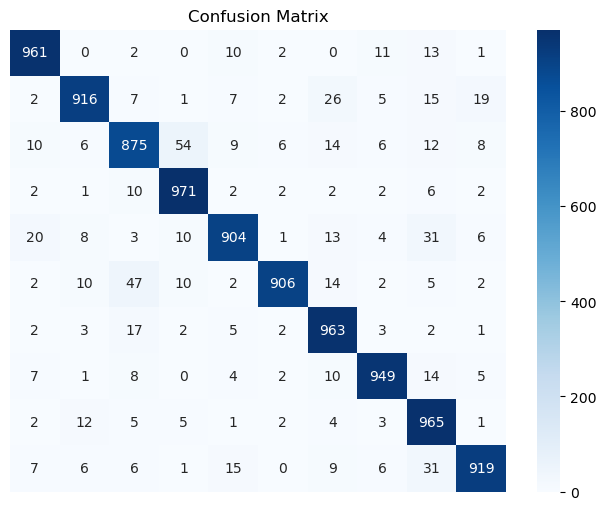

In [20]:
labels = [f"Class {i}" for i in range(1, 11)]
confusion_df = pd.DataFrame(cnf_matrix, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=False, yticklabels=False)
plt.xlabel("")
plt.ylabel("")
plt.title("Confusion Matrix")
plt.show()

### Plotting

In [29]:
import matplotlib.pyplot as plt

with open("./models_data/mn_{}_loss_{}_lr_{}_{}.pkl".format("super_large", 'ce', 0.01, "train_acc"), "rb") as file:
    train_acc = pickle.load(file)
with open("./models_data/mn_{}_loss_{}_lr_{}_{}.pkl".format("super_large", 'ce', 0.01, "train_loss"), "rb") as file:
    train_loss = pickle.load(file)
with open("./models_data/mn_{}_loss_{}_lr_{}_{}.pkl".format("super_large", 'ce', 0.01, "val_acc"), "rb") as file:
    val_acc = pickle.load(file)


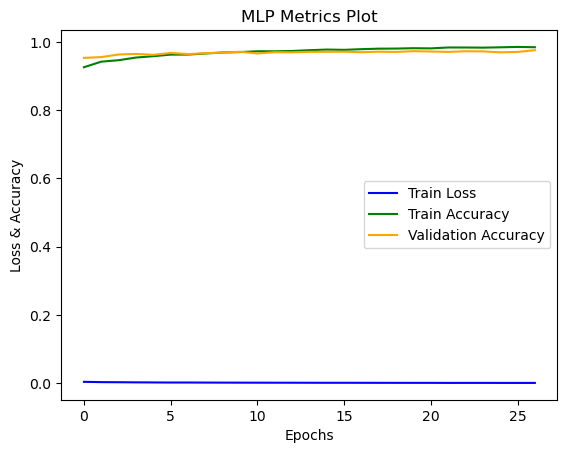

In [33]:
epochs = range(len(train_acc))

plt.figure()

plt.plot(epochs, train_loss, label="Train Loss", color="blue")
plt.plot(epochs, train_acc, label="Train Accuracy", color="green")
plt.plot(epochs, val_acc, label="Validation Accuracy", color="orange")

plt.title("MLP Metrics Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss & Accuracy")
plt.legend()
plt.show()